In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import geopandas as gpd
from pyproj import CRS
import pickle
from datetime import datetime


# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

print(f"EDA started at: {datetime.now()}")






EDA started at: 2025-12-08 15:46:50.590926


In [46]:
# Load cleaned Data 

try:
    df = pd.read_parquet('cleaned_agricultural_data.parquet')
except:
    df = pd.read_csv('cleaned_agricultural_data.csv')

print(f"Dataset loaded: {df.shape}")
print(f"Years: {df['Year'].min()} to {df['Year'].max()}")
print(f"States: {df['State Name'].nunique()}")
print(f"Districts: {df['Dist Name'].nunique()}")





Dataset loaded: (2484, 118)
Years: 2010 to 2017
States: 20
Districts: 311


In [47]:
# 2.Statistical and Distribution Analysis

def comprehensive_statistical_summary(df):
    """Generate comprehensive statistical summary"""
    
    # Basic statistics
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    basic_stats = df[numeric_cols].describe().T
    basic_stats['skewness'] = df[numeric_cols].skew()
    basic_stats['kurtosis'] = df[numeric_cols].kurtosis()
    basic_stats['cv'] = basic_stats['std'] / basic_stats['mean']  # Coefficient of variation
    
    # Normality tests for key columns
    key_columns = [
        'OVERALL_YIELD_Kg_per_ha',
        'TOTAL_PRODUCTION_1000_tons',
        'RICE YIELD (Kg per ha)',
        'WHEAT YIELD (Kg per ha)'
    ]
    
    normality_results = {}
    
    for col in key_columns:
        if col in df.columns:
            col_data = df[col].dropna()
            
            # Shapiro max is 5000 samples
            sample_size = min(len(col_data), 5000)
            
            # Only sample if we have more than 3 values
            if sample_size > 3:
                sample = col_data.sample(sample_size, replace=False)
                stat, p_value = stats.shapiro(sample)
                normality_results[col] = {
                    'statistic': stat,
                    'p_value': p_value
                }
            else:
                normality_results[col] = {
                    'statistic': None,
                    'p_value': None
                }
    
    return basic_stats, normality_results


# Generate statistics
basic_stats, normality_results = comprehensive_statistical_summary(df)

print("Statistical Summary (Key Columns):")
print("=" * 80)
print(basic_stats[['mean', 'std', 'min', '50%', 'max', 'skewness', 'cv']].head(10))



Statistical Summary (Key Columns):
                                      mean          std     min       50%  \
Dist Code                       270.787440   279.103876     1.0   156.000   
Year                           2013.497987     2.292275  2010.0  2013.000   
State Code                        9.579710     4.993319     1.0    10.000   
RICE AREA (1000 ha)             134.141732   156.417189     0.0    79.675   
RICE PRODUCTION (1000 tons)     338.239573   425.917681     0.0   178.145   
RICE YIELD (Kg per ha)         2078.304614  1115.620580     0.0  2178.335   
WHEAT AREA (1000 ha)             95.806710   112.937175     0.0    48.970   
WHEAT PRODUCTION (1000 tons)    310.925588   455.633676     0.0    90.635   
WHEAT YIELD (Kg per ha)        2120.515803  1354.321219     0.0  2075.610   
KHARIF SORGHUM AREA (1000 ha)     7.366912    17.805255     0.0     0.190   

                                     max  skewness        cv  
Dist Code                       917.0000  1.178858  1.

In [48]:
# 3. Time series Analysis and Trend Detection

def analyze_temporal_trends(df):
    """Analyze temporal trends for key metrics"""
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Overall Yield Trend', 'Total Production Trend',
                       'Rice Yield Trend', 'Wheat Yield Trend'),
        vertical_spacing=0.15,
        horizontal_spacing=0.1
    )
    
    # Overall yield trend
    yearly_yield = df.groupby('Year')['OVERALL_YIELD_Kg_per_ha'].mean().reset_index()
    fig.add_trace(
        go.Scatter(x=yearly_yield['Year'], y=yearly_yield['OVERALL_YIELD_Kg_per_ha'],
                  mode='lines+markers', name='Overall Yield'),
        row=1, col=1
    )
    
    # Total production trend
    yearly_prod = df.groupby('Year')['TOTAL_PRODUCTION_1000_tons'].sum().reset_index()
    fig.add_trace(
        go.Scatter(x=yearly_prod['Year'], y=yearly_prod['TOTAL_PRODUCTION_1000_tons'],
                  mode='lines+markers', name='Total Production', line=dict(color='red')),
        row=1, col=2
    )
    
    # Rice yield trend
    if 'RICE YIELD (Kg per ha)' in df.columns:
        rice_yield = df.groupby('Year')['RICE YIELD (Kg per ha)'].mean().reset_index()
        fig.add_trace(
            go.Scatter(x=rice_yield['Year'], y=rice_yield['RICE YIELD (Kg per ha)'],
                      mode='lines+markers', name='Rice Yield', line=dict(color='green')),
            row=2, col=1
        )
    
    # Wheat yield trend
    if 'WHEAT YIELD (Kg per ha)' in df.columns:
        wheat_yield = df.groupby('Year')['WHEAT YIELD (Kg per ha)'].mean().reset_index()
        fig.add_trace(
            go.Scatter(x=wheat_yield['Year'], y=wheat_yield['WHEAT YIELD (Kg per ha)'],
                      mode='lines+markers', name='Wheat Yield', line=dict(color='orange')),
            row=2, col=2
        )
    
    fig.update_layout(height=800, showlegend=True, title_text="Temporal Trends Analysis")
    fig.show()
    
    # Perform structural break detection
    print("\nStructural Break Analysis (Chow Test):")
    print("=" * 80)
    
    for col in ['OVERALL_YIELD_Kg_per_ha', 'TOTAL_PRODUCTION_1000_tons']:
        if col in df.columns:
            # Simple Chow test for 2013 (mid-point)
            pre_2013 = df[df['Year'] < 2013][col].dropna()
            post_2013 = df[df['Year'] >= 2013][col].dropna()
            
            if len(pre_2013) > 10 and len(post_2013) > 10:
                f_stat, p_value = stats.f_oneway(pre_2013, post_2013)
                print(f"{col}: F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")
                if p_value < 0.05:
                    print(f"  → Significant structural break detected at 2013")

analyze_temporal_trends(df)





Structural Break Analysis (Chow Test):
OVERALL_YIELD_Kg_per_ha: F-statistic = 8.6579, p-value = 0.0033
  → Significant structural break detected at 2013
TOTAL_PRODUCTION_1000_tons: F-statistic = 0.3225, p-value = 0.5702


In [49]:
# 4. Spartial Analysis and Geographical pattern  

def analyze_spatial_patterns(df):
    """Analyze spatial patterns in agricultural productivity"""
    
    # Calculate state-level statistics
    state_stats = df.groupby('State Name').agg({
        'OVERALL_YIELD_Kg_per_ha': ['mean', 'std', 'min', 'max'],
        'TOTAL_PRODUCTION_1000_tons': 'sum',
        'TOTAL_AREA_1000_ha': 'sum',
        'CROP_DIVERSIFICATION_INDEX': 'mean',
        'Dist Name': 'nunique'
    }).round(2)
    
    state_stats.columns = ['_'.join(col).strip() for col in state_stats.columns.values]
    state_stats = state_stats.rename(columns={'Dist Name_nunique': 'Number_of_Districts'})
    
    # Calculate productivity ranking
    state_stats['Productivity_Rank'] = state_stats['OVERALL_YIELD_Kg_per_ha_mean'].rank(ascending=False)
    state_stats['Stability_Score'] = 1 / (1 + state_stats['OVERALL_YIELD_Kg_per_ha_std'])
    state_stats['Efficiency_Score'] = state_stats['TOTAL_PRODUCTION_1000_tons_sum'] / state_stats['TOTAL_AREA_1000_ha_sum']
    
    # Create visualization
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Average Yield by State', 'Total Production by State',
                       'Crop Diversification Index', 'Agricultural Efficiency'),
        specs=[[{'type': 'bar'}, {'type': 'bar'}],
               [{'type': 'bar'}, {'type': 'bar'}]]
    )
    
    # Sort states by yield
    state_stats_sorted = state_stats.sort_values('OVERALL_YIELD_Kg_per_ha_mean', ascending=False)
    
    # Plot 1: Average Yield
    fig.add_trace(
        go.Bar(x=state_stats_sorted.index, y=state_stats_sorted['OVERALL_YIELD_Kg_per_ha_mean'],
               name='Avg Yield', marker_color='lightgreen'),
        row=1, col=1
    )
    
    # Plot 2: Total Production
    fig.add_trace(
        go.Bar(x=state_stats_sorted.index, y=state_stats_sorted['TOTAL_PRODUCTION_1000_tons_sum'],
               name='Total Production', marker_color='lightblue'),
        row=1, col=2
    )
    
    # Plot 3: Crop Diversification
    fig.add_trace(
        go.Bar(x=state_stats_sorted.index, y=state_stats_sorted['CROP_DIVERSIFICATION_INDEX_mean'],
               name='Diversification', marker_color='orange'),
        row=2, col=1
    )
    
    # Plot 4: Efficiency
    fig.add_trace(
        go.Bar(x=state_stats_sorted.index, y=state_stats_sorted['Efficiency_Score'],
               name='Efficiency', marker_color='red'), 
        row=2, col=2
    )
    
    fig.update_layout(height=800, showlegend=True, title_text="State-wise Agricultural Performance")
    fig.show()
    
    return state_stats

state_stats = analyze_spatial_patterns(df)
print("\nTop 5 States by Average Yield:")
print(state_stats.sort_values('OVERALL_YIELD_Kg_per_ha_mean', ascending=False).head())



 



    


Top 5 States by Average Yield:
               OVERALL_YIELD_Kg_per_ha_mean  OVERALL_YIELD_Kg_per_ha_std  \
State Name                                                                 
Punjab                              3676.86                       422.25   
Haryana                             3011.29                       727.10   
Uttar Pradesh                       2535.68                       874.34   
Bihar                               2241.32                       426.51   
Tamil Nadu                          2181.59                      1023.35   

               OVERALL_YIELD_Kg_per_ha_min  OVERALL_YIELD_Kg_per_ha_max  \
State Name                                                                
Punjab                             2919.75                      4738.06   
Haryana                            1758.97                      4370.01   
Uttar Pradesh                       625.69                      5650.66   
Bihar                              1365.20                  


Strong Correlations (|r| > 0.7):
OVERALL_YIELD_Kg_per_ha ↔ PRODUCTIVITY_EFFICIENCY: 1.000

Principal Component Analysis:


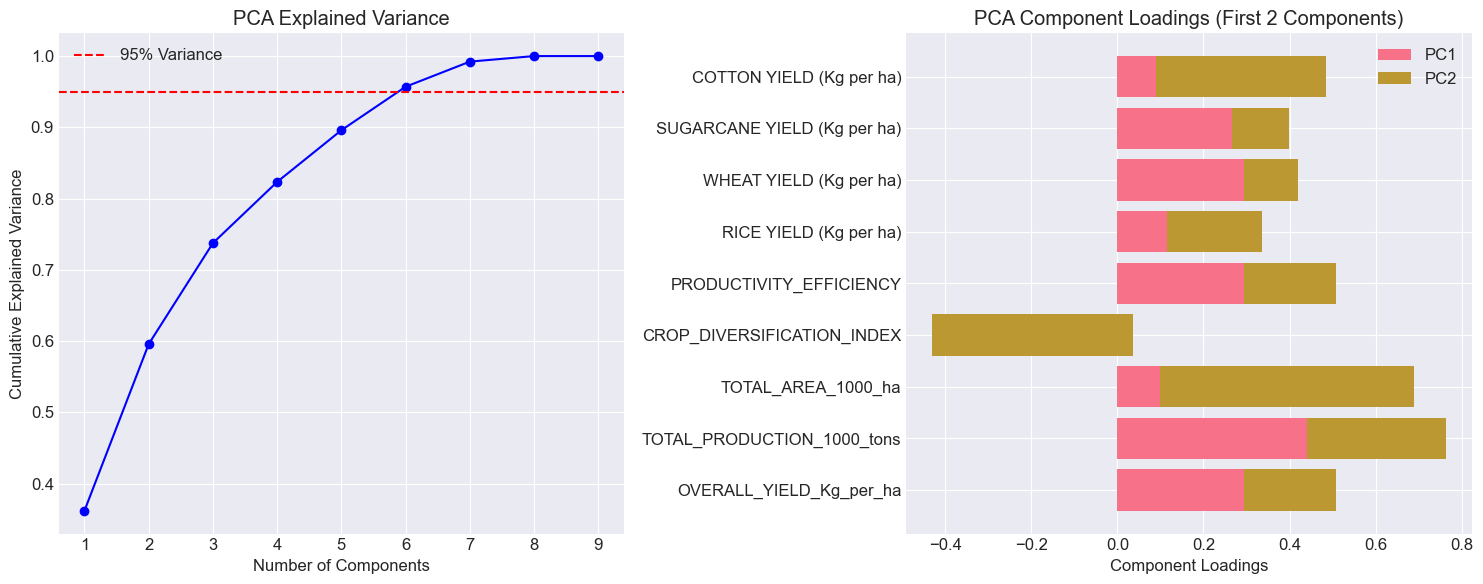


Number of components for 95% variance: 6


In [50]:
def analyze_correlations(df):
    """Perform comprehensive correlation analysis"""
    
    # Select key numerical features
    key_features = [
        'OVERALL_YIELD_Kg_per_ha', 'TOTAL_PRODUCTION_1000_tons', 'TOTAL_AREA_1000_ha',
        'CROP_DIVERSIFICATION_INDEX', 'PRODUCTIVITY_EFFICIENCY',
        'RICE YIELD (Kg per ha)', 'WHEAT YIELD (Kg per ha)',
        'SUGARCANE YIELD (Kg per ha)', 'COTTON YIELD (Kg per ha)'
    ]
    
    # Filter available features
    available_features = [f for f in key_features if f in df.columns]
    
    # Calculate correlation matrix
    correlation_matrix = df[available_features].corr()
    
    # Create heatmap
    fig = go.Figure(data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.index,
        colorscale='RdBu',
        zmid=0,
        text=correlation_matrix.round(2).values,
        texttemplate='%{text}',
        textfont={"size": 10},
        hoverongaps=False
    ))
    
    fig.update_layout(
        title='Feature Correlation Matrix',
        xaxis_title='Features',
        yaxis_title='Features',
        height=600,
        width=800
    )
    
    fig.show()
    
    # Identify strong correlations
    strong_correlations = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                strong_correlations.append((
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j],
                    correlation_matrix.iloc[i, j]
                ))
    
    print("\nStrong Correlations (|r| > 0.7):")
    print("=" * 80)
    for corr in strong_correlations:
        print(f"{corr[0]} ↔ {corr[1]}: {corr[2]:.3f}")
    
    # Perform PCA for dimensionality reduction
    print("\nPrincipal Component Analysis:")
    print("=" * 80)
    
    # Standardize data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[available_features].fillna(0))
    
    # Apply PCA
    pca = PCA()
    pca_result = pca.fit_transform(scaled_data)
    
    # Plot explained variance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_), 'bo-')
    ax1.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
    ax1.set_xlabel('Number of Components')
    ax1.set_ylabel('Cumulative Explained Variance')
    ax1.set_title('PCA Explained Variance')
    ax1.legend()
    ax1.grid(True)
    
    # Plot component loadings
    components_to_show = min(3, len(available_features))
    loadings = pca.components_[:components_to_show].T
    
    ax2.barh(range(len(available_features)), loadings[:, 0], label='PC1')
    ax2.barh(range(len(available_features)), loadings[:, 1], left=loadings[:, 0], label='PC2')
    ax2.set_yticks(range(len(available_features)))
    ax2.set_yticklabels(available_features)
    ax2.set_xlabel('Component Loadings')
    ax2.set_title('PCA Component Loadings (First 2 Components)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nNumber of components for 95% variance: {np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0] + 1}")
    
    return correlation_matrix, pca

correlation_matrix, pca = analyze_correlations(df)


In [51]:
#6 Clustering Analysis


def perform_clustering_analysis(df, n_clusters=5):
    """Perform clustering analysis to identify similar districts"""
    
    # Prepare features for clustering
    cluster_features = [
        'OVERALL_YIELD_Kg_per_ha', 'TOTAL_PRODUCTION_1000_tons',
        'TOTAL_AREA_1000_ha', 'CROP_DIVERSIFICATION_INDEX',
        'PRODUCTIVITY_EFFICIENCY'
    ]
    
    # Filter available features
    available_cluster_features = [f for f in cluster_features if f in df.columns]
    
    # Get district-level averages
    district_features = df.groupby(['State Name', 'Dist Name'])[available_cluster_features].mean().reset_index()
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(district_features[available_cluster_features])
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    district_features['Cluster'] = kmeans.fit_predict(scaled_features)
    
    # Analyze cluster characteristics
    cluster_stats = district_features.groupby('Cluster')[available_cluster_features].agg(['mean', 'std'])
    
    # Create visualization
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Cluster Distribution', 'Yield vs Diversification',
                       'Production vs Area', 'Cluster Characteristics'),
        specs=[[{'type': 'pie'}, {'type': 'scatter'}],
               [{'type': 'scatter'}, {'type': 'bar'}]]
    )
    
    # Pie chart for cluster distribution
    cluster_counts = district_features['Cluster'].value_counts().sort_index()
    fig.add_trace(
        go.Pie(labels=[f'Cluster {i}' for i in cluster_counts.index],
               values=cluster_counts.values, name='Cluster Distribution'),
        row=1, col=1
    )
    
    # Scatter plot: Yield vs Diversification
    fig.add_trace(
        go.Scatter(x=district_features['OVERALL_YIELD_Kg_per_ha'],
                   y=district_features['CROP_DIVERSIFICATION_INDEX'],
                   mode='markers',
                   marker=dict(color=district_features['Cluster'], colorscale='viridis', showscale=True),
                   text=district_features['Dist Name'],
                   hoverinfo='text+x+y',
                   name='Districts'),
        row=1, col=2
    )
    fig.update_xaxes(title_text='Overall Yield', row=1, col=2)
    fig.update_yaxes(title_text='Diversification Index', row=1, col=2)
    
    # Scatter plot: Production vs Area
    fig.add_trace(
        go.Scatter(x=district_features['TOTAL_AREA_1000_ha'],
                   y=district_features['TOTAL_PRODUCTION_1000_tons'],
                   mode='markers',
                   marker=dict(color=district_features['Cluster'], colorscale='plasma', showscale=False),
                   text=district_features['Dist Name'],
                   hoverinfo='text+x+y',
                   name='Districts'),
        row=2, col=1
    )
    fig.update_xaxes(title_text='Total Area', row=2, col=1)
    fig.update_yaxes(title_text='Total Production', row=2, col=1)
    
    # Bar chart for cluster means
    for i, feature in enumerate(['OVERALL_YIELD_Kg_per_ha', 'TOTAL_PRODUCTION_1000_tons']):
        if feature in available_cluster_features:
            fig.add_trace(
                go.Bar(x=[f'Cluster {j}' for j in range(n_clusters)],
                       y=cluster_stats[(feature, 'mean')],
                       name=feature,
                       showlegend=(i==0)),
                row=2, col=2
            )
    
    fig.update_layout(height=800, showlegend=True, title_text="District Clustering Analysis")
    fig.show()
    
    # Print cluster insights
    print("\nCluster Characteristics:")
    print("=" * 80)
    for cluster_id in range(n_clusters):
        cluster_data = district_features[district_features['Cluster'] == cluster_id]
        print(f"\nCluster {cluster_id} ({len(cluster_data)} districts):")
        print(f"  Average Yield: {cluster_data['OVERALL_YIELD_Kg_per_ha'].mean():.2f}")
        print(f"  Average Production: {cluster_data['TOTAL_PRODUCTION_1000_tons'].mean():.2f}")
        print(f"  Average Diversification: {cluster_data['CROP_DIVERSIFICATION_INDEX'].mean():.3f}")
        print(f"  States: {', '.join(cluster_data['State Name'].unique()[:5])}")
    
    return district_features, kmeans

district_clusters, kmeans_model = perform_clustering_analysis(df, n_clusters=5)




Cluster Characteristics:

Cluster 0 (100 districts):
  Average Yield: 1304.12
  Average Production: 683.76
  Average Diversification: 0.199
  States: Andhra Pradesh, Assam, Chhattisgarh, Gujarat, Himachal Pradesh

Cluster 1 (71 districts):
  Average Yield: 2441.89
  Average Production: 1405.65
  Average Diversification: 0.271
  States: Andhra Pradesh, Bihar, Gujarat, Haryana, Karnataka

Cluster 2 (52 districts):
  Average Yield: 1494.01
  Average Production: 433.76
  Average Diversification: 0.476
  States: Assam, Chhattisgarh, Gujarat, Himachal Pradesh, Jharkhand

Cluster 3 (23 districts):
  Average Yield: 3739.48
  Average Production: 2625.19
  Average Diversification: 0.313
  States: Andhra Pradesh, Bihar, Haryana, Maharashtra, Punjab

Cluster 4 (65 districts):
  Average Yield: 1336.58
  Average Production: 1620.30
  Average Diversification: 0.189
  States: Andhra Pradesh, Chhattisgarh, Gujarat, Haryana, Karnataka


Statistical Anomaly Detection (Z-score > 3):

OVERALL_YIELD_Kg_per_ha:
  Number of anomalies: 21
  Anomaly percentage: 0.85%
  Sample anomalies:  State Name Dist Name  Year  OVERALL_YIELD_Kg_per_ha
Maharashtra  Kolhapur  2016              4568.415432
Maharashtra  Kolhapur  2017              4786.070654
     Punjab  Ludhiana  2017              4511.207387

TOTAL_PRODUCTION_1000_tons:
  Number of anomalies: 43
  Anomaly percentage: 1.73%
  Sample anomalies: State Name Dist Name  Year  TOTAL_PRODUCTION_1000_tons
   Haryana    Hissar  2010                   4826.6623
   Haryana    Hissar  2011                   4569.5197
   Haryana    Hissar  2012                   4606.3649

RICE YIELD (Kg per ha):
  Number of anomalies: 0
  Anomaly percentage: 0.00%

WHEAT YIELD (Kg per ha):
  Number of anomalies: 0
  Anomaly percentage: 0.00%

Isolation Forest Anomalies: 125 (5.03%)


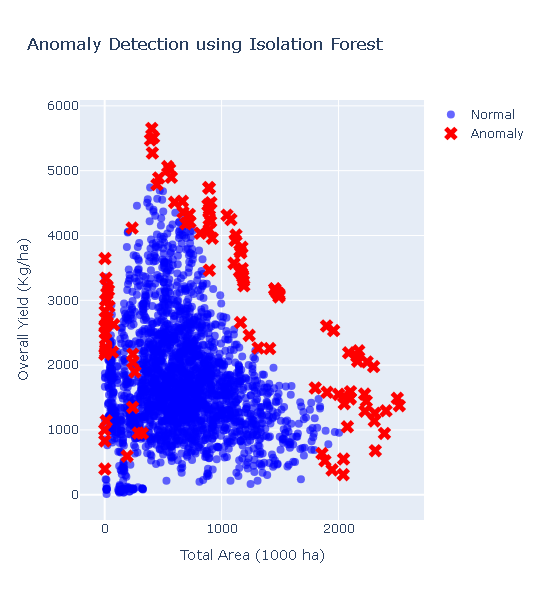

In [52]:
#7. Anomaly Detection

def detect_anomalies(df):
    """Detect anomalies and outliers in the data"""
    
    # Method 1: Statistical approach using Z-score
    print("Statistical Anomaly Detection (Z-score > 3):")
    print("=" * 80)
    
    anomaly_cols = [
        'OVERALL_YIELD_Kg_per_ha', 
        'TOTAL_PRODUCTION_1000_tons',
        'RICE YIELD (Kg per ha)', 
        'WHEAT YIELD (Kg per ha)'
    ]
    
    anomalies = {}
    
    for col in anomaly_cols:
        if col in df.columns:

            # SAFE & FIXED Z-SCORE CALCULATION  
            col_data = df[col]

            # Compute z-scores without breaking index alignment
            z_scores = stats.zscore(col_data, nan_policy='omit')

            # Convert to absolute values and handle NaNs safely
            z_scores = np.abs(z_scores)

            # Mask automatically aligns with df rows because we never dropped anything
            mask = (z_scores > 3)

            # Filter anomalies safely
            col_anomalies = df[mask]
            anomalies[col] = col_anomalies

            print(f"\n{col}:")
            print(f"  Number of anomalies: {len(col_anomalies)}")
            print(f"  Anomaly percentage: {len(col_anomalies)/len(df)*100:.2f}%")
            
            if len(col_anomalies) > 0:
                print(
                    f"  Sample anomalies: "
                    f"{col_anomalies[['State Name', 'Dist Name', 'Year', col]].head(3).to_string(index=False)}"
                )
    
    # Method 2: Isolation Forest
    from sklearn.ensemble import IsolationForest
    
    iso_features = [
        'OVERALL_YIELD_Kg_per_ha', 
        'TOTAL_PRODUCTION_1000_tons',
        'TOTAL_AREA_1000_ha', 
        'CROP_DIVERSIFICATION_INDEX'
    ]
    iso_features = [f for f in iso_features if f in df.columns]
    
    iso_data = df[iso_features].fillna(0)
    
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_predictions = iso_forest.fit_predict(iso_data)
    
    df['Isolation_Forest_Anomaly'] = iso_predictions
    iso_anomalies = df[df['Isolation_Forest_Anomaly'] == -1]
    
    print(f"\nIsolation Forest Anomalies: {len(iso_anomalies)} ({len(iso_anomalies)/len(df)*100:.2f}%)")
    
    # Visualize anomalies
    fig = go.Figure()
    
    # Normal points
    normal = df[df['Isolation_Forest_Anomaly'] == 1]
    fig.add_trace(go.Scatter(
        x=normal['TOTAL_AREA_1000_ha'],
        y=normal['OVERALL_YIELD_Kg_per_ha'],
        mode='markers',
        name='Normal',
        marker=dict(color='blue', size=8, opacity=0.6)
    ))
    
    # Anomalies
    fig.add_trace(go.Scatter(
        x=iso_anomalies['TOTAL_AREA_1000_ha'],
        y=iso_anomalies['OVERALL_YIELD_Kg_per_ha'],
        mode='markers',
        name='Anomaly',
        marker=dict(color='red', size=12, symbol='x')
    ))
    
    fig.update_layout(
        title='Anomaly Detection using Isolation Forest',
        xaxis_title='Total Area (1000 ha)',
        yaxis_title='Overall Yield (Kg/ha)',
        height=600
    )
    
    fig.show()
    
    return anomalies, iso_anomalies

anomalies, iso_anomalies = detect_anomalies(df)

Crop Diversification Analysis:

Yearly Diversification Trends:
        HHI  Entropy  Total_Crops
Year                             
2010  0.255    1.821       38.529
2011  0.271    1.758       37.123
2012  0.247    1.842       39.529
2013  0.258    1.781       37.135
2014  0.254    1.801       36.619
2015  0.259    1.776       35.935
2016  0.277    1.742       36.122
2017  0.290    1.675       34.748

State-level Diversification (sorted by HHI - lower is more diversified):
                HHI_mean  HHI_std  Entropy_mean  Entropy_std  Total_Crops_mean
State                                                                         
Karnataka          0.182    0.116         2.150        0.486            43.368
Rajasthan          0.190    0.051         1.985        0.243            42.721
Madhya Pradesh     0.200    0.067         1.963        0.267            40.662
Andhra Pradesh     0.206    0.079         2.040        0.308            45.000
Uttarakhand        0.215    0.042         1.902  

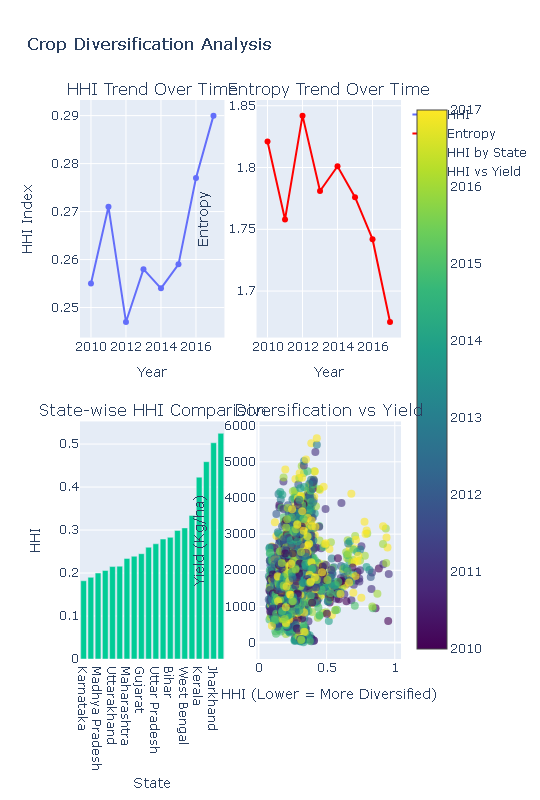

In [55]:
# 8. Crop Diversification Analysis

def analyze_crop_diversification(df):
    """Analyze crop diversification patterns"""
    
    # Calculate Herfindahl-Hirschman Index (HHI) for each district-year
    area_columns = [col for col in df.columns if 'AREA' in col and '1000 ha' in col]
    
    diversification_analysis = []
    for idx, row in df.iterrows():
        areas = row[area_columns]
        total_area = areas.sum()
        
        if total_area > 0:
            proportions = areas / total_area

            # ---- SAFEST FIX: Convert to numpy array (prevents .log error) ----
            proportions_np = proportions.to_numpy(dtype=float)

            # HHI
            hhi = np.sum(proportions_np ** 2)

            # Entropy (fully safe numeric operations)
            entropy = -np.sum(proportions_np * np.log(proportions_np + 1e-10))
            # -------------------------------------------------------------------

            diversification_analysis.append({
                'State': row['State Name'],
                'District': row['Dist Name'],
                'Year': row['Year'],
                'HHI': hhi,
                'Entropy': entropy,
                'Total_Crops': (areas > 0).sum(),
                'Dominant_Crop': areas.idxmax() if not areas.empty else None
            })
    
    diversification_df = pd.DataFrame(diversification_analysis)
    
    # Analyze trends
    print("Crop Diversification Analysis:")
    print("=" * 80)
    
    # Yearly trends
    yearly_diversification = diversification_df.groupby('Year').agg({
        'HHI': 'mean',
        'Entropy': 'mean',
        'Total_Crops': 'mean'
    }).round(3)
    
    print("\nYearly Diversification Trends:")
    print(yearly_diversification)
    
    # State-level comparison
    state_diversification = diversification_df.groupby('State').agg({
        'HHI': ['mean', 'std'],
        'Entropy': ['mean', 'std'],
        'Total_Crops': 'mean'
    }).round(3)
    
    state_diversification.columns = ['_'.join(col).strip() for col in state_diversification.columns.values]
    state_diversification = state_diversification.sort_values('HHI_mean')
    
    print("\nState-level Diversification (sorted by HHI - lower is more diversified):")
    print(state_diversification.head(10))
    
    # Visualization
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('HHI Trend Over Time', 'Entropy Trend Over Time',
                       'State-wise HHI Comparison', 'Diversification vs Yield'),
        vertical_spacing=0.15
    )
    
    # HHI trend
    fig.add_trace(
        go.Scatter(x=yearly_diversification.index, y=yearly_diversification['HHI'],
                  mode='lines+markers', name='HHI'),
        row=1, col=1
    )
    
    # Entropy trend
    fig.add_trace(
        go.Scatter(x=yearly_diversification.index, y=yearly_diversification['Entropy'],
                  mode='lines+markers', name='Entropy', line=dict(color='red')),
        row=1, col=2
    )
    
    # State HHI comparison
    fig.add_trace(
        go.Bar(x=state_diversification.index, y=state_diversification['HHI_mean'],
               name='HHI by State'),
        row=2, col=1
    )
    
    # Diversification vs Yield
    merged_data = pd.merge(
        diversification_df,
        df[['State Name', 'Dist Name', 'Year', 'OVERALL_YIELD_Kg_per_ha']],
        left_on=['State', 'District', 'Year'],
        right_on=['State Name', 'Dist Name', 'Year']
    )
    
    fig.add_trace(
        go.Scatter(
            x=merged_data['HHI'],
            y=merged_data['OVERALL_YIELD_Kg_per_ha'],
            mode='markers',
            name='HHI vs Yield',
            marker=dict(size=8, opacity=0.6, color=merged_data['Year'],
                        colorscale='viridis', showscale=True)
        ),
        row=2, col=2
    )
    
    fig.update_layout(height=800, showlegend=True, title_text="Crop Diversification Analysis")
    fig.update_xaxes(title_text="Year", row=1, col=1)
    fig.update_xaxes(title_text="Year", row=1, col=2)
    fig.update_xaxes(title_text="State", row=2, col=1)
    fig.update_xaxes(title_text="HHI (Lower = More Diversified)", row=2, col=2)
    fig.update_yaxes(title_text="HHI Index", row=1, col=1)
    fig.update_yaxes(title_text="Entropy", row=1, col=2)
    fig.update_yaxes(title_text="HHI", row=2, col=1)
    fig.update_yaxes(title_text="Yield (Kg/ha)", row=2, col=2)
    
    fig.show()
    
    return diversification_df

diversification_df = analyze_crop_diversification(df)   
   
    


In [56]:
# 9. Advanced Statistical Analysis

def advanced_statistical_analysis(df):
    """Perform advanced statistical analyses"""
    
    print("Advanced Statistical Analysis")
    print("=" * 80)
    
    # 1. Stationarity test for time series
    print("\n1. Time Series Stationarity Tests:")
    print("-" * 40)
    
    # Prepare time series data (state-level average yield)
    time_series_data = df.groupby('Year')['OVERALL_YIELD_Kg_per_ha'].mean()
    
    # ADF test
    adf_result = adfuller(time_series_data)
    print(f"ADF Test:")
    print(f"  ADF Statistic: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Critical Values: {adf_result[4]}")
    
    # KPSS test
    kpss_result = kpss(time_series_data, regression='c')
    print(f"\nKPSS Test:")
    print(f"  KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"  p-value: {kpss_result[1]:.4f}")
    
    # 2. Regression analysis
    print("\n2. Regression Analysis - Factors affecting yield:")
    print("-" * 40)
    
    # Prepare regression data
    reg_features = ['TOTAL_AREA_1000_ha', 'CROP_DIVERSIFICATION_INDEX', 
                    'YEAR_SINCE_2010', 'PRODUCTIVITY_EFFICIENCY']
    reg_features = [f for f in reg_features if f in df.columns]
    
    X = df[reg_features].fillna(0)
    y = df['OVERALL_YIELD_Kg_per_ha']
    
    # Add constant
    X = sm.add_constant(X)
    
    # Fit OLS model
    model = sm.OLS(y, X).fit()
    
    print(model.summary().tables[1])
    
    # 3. Hypothesis testing
    print("\n3. Hypothesis Testing:")
    print("-" * 40)
    
    # Compare yields between states
    states_to_compare = df['State Name'].value_counts().index[:2]
    state1_yield = df[df['State Name'] == states_to_compare[0]]['OVERALL_YIELD_Kg_per_ha']
    state2_yield = df[df['State Name'] == states_to_compare[1]]['OVERALL_YIELD_Kg_per_ha']
    
    # T-test
    t_stat, p_value = stats.ttest_ind(state1_yield, state2_yield, equal_var=False)
    print(f"T-test: {states_to_compare[0]} vs {states_to_compare[1]}")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print(f"  → Statistically significant difference in yields")
    else:
        print(f"  → No significant difference in yields")
    
    # 4. ANOVA for multiple groups
    print("\n4. ANOVA - Yield across states:")
    print("-" * 40)
    
    # Select top 5 states
    top_states = df['State Name'].value_counts().index[:5]
    anova_data = [df[df['State Name'] == state]['OVERALL_YIELD_Kg_per_ha'] for state in top_states]
    
    f_stat, p_value = stats.f_oneway(*anova_data)
    print(f"ANOVA Results:")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    
    return model

regression_model = advanced_statistical_analysis(df)








Advanced Statistical Analysis

1. Time Series Stationarity Tests:
----------------------------------------
ADF Test:
  ADF Statistic: -8.5261
  p-value: 0.0000
  Critical Values: {'1%': np.float64(-6.045114), '5%': np.float64(-3.9292800000000003), '10%': np.float64(-2.98681)}

KPSS Test:
  KPSS Statistic: 0.3709
  p-value: 0.0897

2. Regression Analysis - Factors affecting yield:
----------------------------------------
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                             nan        nan        nan        nan         nan         nan
TOTAL_AREA_1000_ha                nan        nan        nan        nan         nan         nan
CROP_DIVERSIFICATION_INDEX        nan        nan        nan        nan         nan         nan
YEAR_SINCE_2010                   nan        nan        nan        nan         nan         nan
PRODUC

In [ ]:
# 10. Save Analysis Results





